# DJ 30 Trading BOT


In this project, we try to build a trading Bot which rely trading decicion on a Machine Learning of 3 main components that we beleive that are important on determining trading strategy and timing. These components are Fundamental, Technical, and Sentiment In each component, we biuld buy/sell signals based on the represent indicators. Benefit from haveing Bot trading DJ 30 is to rely decision on these signals we have from the core components and reduce emotion from determining strategy and timing to get in and out of DJ 30. 

DJ 30 are AXP, AMGN, AAPL, BA, CAT, CSCO, CVX, GS, HD, HON, IBM, INTC, JNJ, KO, JPM, MCD, MMM, MRK, MSFT, NKE, PG, TRV, UNH, CRM, VZ, V, WBA, WMT, DIS, DOW

In [43]:
#Import libraries
import numpy as np
import pandas as pd
#import ta
import os
import ffn as ffn
import bt

from datetime import datetime, timedelta

import hvplot.pandas
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use
%matplotlib inline
print("Libraries imported")

Libraries imported


## Functions

In [44]:
#Function for building data of each stock in Long horizon coverage
def build_input_long(ticker):
    stocks = ticker
    end_date = datetime.now() - timedelta(3)
    start_date = end_date - timedelta(365*1)
    data = yf.download(stocks, start=start_date, end=end_date)
    data = data['Close'].dropna()
    return_df = data.pct_change()
    return_df = return_df.dropna()
    filter_fundamental_df  = fundamental_df[fundamental_df.Ticker.isin([ticker])]
    filter_rsi_df  = rsi_df[rsi_df.Ticker.isin([ticker])]
    filter_sentiment_df  = sentiment_df[sentiment_df.Ticker.isin([ticker])]
    df= pd.concat([return_df,filter_fundamental_df,filter_rsi_df,filter_sentiment_df], axis=1, join='outer')
    df.drop('Ticker', axis=1, inplace=True)
    df = df[df['Close'].notna()]
    df['Positive_Return'] = np.where(df['Close'] > 0, 1.0, 0.0)
    return df

In [45]:
#Function for building data of each stock in Short horizon coverage
def build_input_short(ticker):
    stocks = ticker
    end_date = datetime.now() - timedelta(3)
    start_date = end_date - timedelta(33)
    data = yf.download(stocks, start=start_date, end=end_date)
    data = data['Close'].dropna()
    return_df = data.pct_change()
    return_df = return_df.dropna()
    filter_fundamental_df  = fundamental_df[fundamental_df.Ticker.isin([ticker])]
    filter_rsi_df  = rsi_df[rsi_df.Ticker.isin([ticker])]
    filter_sentiment_df  = sentiment_df[sentiment_df.Ticker.isin([ticker])]
    df= pd.concat([return_df,filter_fundamental_df,filter_rsi_df,filter_sentiment_df], axis=1, join='outer')
    df.drop('Ticker', axis=1, inplace=True)
    df = df[df['Close'].notna()]
    df['Positive_Return'] = np.where(df['Close'] > 0, 1.0, 0.0)
    return df

In [46]:
#Data Preparation Function (Long Horizon)
#x_var_list_long = ["ROE_Sig", "OpMargin_Sig","DebtEq_Sig","Fscore_Sig","RSI"]

def X_train_long(df):
    x_var_list_long = ["ROE_Sig", "OpMargin_Sig","DebtEq_Sig","Fscore_Sig","RSI"]
    X = df[x_var_list_long].shift(1)
    split = int(0.7 * len(df.Close))
    X_train = X[: split].dropna()   
    return X_train

def X_test_long(df):
    x_var_list_long = ["ROE_Sig", "OpMargin_Sig","DebtEq_Sig","Fscore_Sig","RSI"]
    split = int(0.7 * len(df.Close))
    X = df[x_var_list_long].shift(1)
    X_test = X[split:].dropna()
    return X_test


def y_train_long(df):
    y = df["Positive_Return"]
    split = int(0.7 * len(df.Close))
    y_train = y[1: split].dropna()
    return y_train

def y_test_long(df):
    y = df["Positive_Return"]
    split = int(0.7 * len(df.Close))
    y_test = y[split:-1].dropna()
    return y_test

In [47]:
#Data Preparation Function (Short Horizon)
#x_var_list_short = ["ROE_Sig", "OpMargin_Sig","DebtEq_Sig","Fscore_Sig","RSI","Sentiment"]
def X_train_short(df):
    x_var_list_short = ["ROE_Sig", "OpMargin_Sig","DebtEq_Sig","Fscore_Sig","RSI","Sentiment"]
    X = df[x_var_list_short].shift(1)
    split = int(0.7 * len(df.Close))
    X_train = X[: split].dropna()   
    return X_train

def X_test_short(df):
    x_var_list_short = ["ROE_Sig", "OpMargin_Sig","DebtEq_Sig","Fscore_Sig","RSI","Sentiment"]
    X = df[x_var_list_short].shift(1)
    split = int(0.7 * len(df.Close))
    X_test = X[split:].dropna()
    return X_test

def y_train_short(df):
    y = df["Positive_Return"]
    split = int(0.7 * len(df.Close))
    y_train = y[1: split].dropna()
    return y_train

def y_test_short(df):
    y = df["Positive_Return"]
    split = int(0.7 * len(df.Close))
    y_test = y[split:-1].dropna()
    return y_test

In [48]:
#ML function
def random_forest(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.datasets import make_classification
    model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions = model.predict(X_test)
    results = y_test.to_frame()
    results["Predicted_Value"] = predictions
    return results

## Features

We build signal data  from 3 main components which are..
1. Fundamental: ROE, Operation margin, Debt-to-Equity ratio, and Pietroskie F-score
2. Technical: Bollinger Band, RSI, MACD
3. Sentiment: News relevant to company name
Sources of these data are XXX, Yahoo Finance, and News API.
However, we can pull News API by just 1 month back bacause of limitation of using trial account. With this limitation, we plan to split the data  into long-horizon and short-horizon data sets. In thr longer-horizon data, the features used in ML model are just Fundamental and Technical. For short-horizon, all 3 main features will be included in the ML model.

In [49]:
#Import cvs
#Fundamental
fundamental_df = pd.read_csv(r"C:\Users\khuli\OneDrive\Documents\BCS\Project2\Project-2\fundamental_signals_new.csv")
fundamental_df.set_index(pd.to_datetime(fundamental_df['Date'], infer_datetime_format=True), inplace=True)
fundamental_df.drop(columns=['Date'], inplace=True)


#Technical
#technical_df = pd.read_csv(r"C:\Users\khuli\OneDrive\Documents\BCS\Project2\technical_signal.csv")
rsi_df = pd.read_csv(r"C:\Users\khuli\OneDrive\Documents\BCS\Project2\rsi_signal.csv")
rsi_df.set_index(pd.to_datetime(rsi_df['Date'], infer_datetime_format=True), inplace=True)
rsi_df.drop(columns=['Date'], inplace=True)
#macd_df = pd.read_csv(r"C:\Users\khuli\OneDrive\Documents\BCS\Project2\rsi_signal.csv")

#Sentiment
sentiment_df = pd.read_csv(r"C:\Users\khuli\OneDrive\Documents\BCS\Project2\sentiment_signal.csv")
sentiment_df.set_index(pd.to_datetime(sentiment_df['Date'], infer_datetime_format=True), inplace=True)
sentiment_df.drop(columns=['Date'], inplace=True)


In [50]:
fundamental_df.head()

,Ticker,ROE_Sig,OpMargin_Sig,DebtEq_Sig,Fscore_Sig
Date,,,,,
2007-01-03,AAPL,0.0,0.0,1.0,0.0
2007-01-04,AAPL,0.0,0.0,1.0,0.0
2007-01-05,AAPL,0.0,0.0,1.0,0.0
2007-01-08,AAPL,0.0,0.0,1.0,0.0
2007-01-09,AAPL,0.0,0.0,1.0,0.0


In [51]:
sentiment_df.head()

,Ticker,Sentiment
Date,,
2020-09-12,AXP,0
2020-09-13,AXP,0
2020-09-14,AXP,0
2020-09-15,AXP,0
2020-09-16,AXP,1


In [52]:
rsi_df.head()

,Ticker,RSI
Date,,
2019-04-09,AAPL,-1
2019-04-10,AAPL,-1
2019-04-11,AAPL,0
2019-04-12,AAPL,0
2019-04-15,AAPL,0


## DF management preparation

We split ML into (1) Long-horizon model and (2) Short horizon model because of limitation from getting sentiment signal

### DF for Longer horizon coverage

AXP, AMGN, AAPL, BA, CAT, CSCO, CVX, GS, HD, HON, IBM, INTC, JNJ, KO, JPM, MCD, MMM, MRK, MSFT, NKE, PG, TRV, UNH, CRM, VZ, V, WBA, WMT, DIS, DOW

In [81]:
ticker = "MSFT"

In [82]:
# df for Long horizon model
df = build_input_long(ticker)
df.tail(10)

[*********************100%***********************]  1 of 1 completed


,Close,ROE_Sig,OpMargin_Sig,DebtEq_Sig,Fscore_Sig,RSI,Sentiment,Positive_Return
Date,,,,,,,,
2020-10-01,0.010127,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-10-02,-0.029511,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-10-05,0.020321,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-10-06,-0.021247,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-10-07,0.019037,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-10-08,0.003574,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-10-09,0.024836,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-10-12,0.025902,NaN,NaN,NaN,NaN,0.0,0.0,1.0
2020-10-13,0.006594,0.0,0.0,0.0,1.0,0.0,1.0,1.0


### DF for Shorter horizon coverage

In [83]:
# df for Short horizon model
df_2 = build_input_short(ticker)
df_2.sample(10)

[*********************100%***********************]  1 of 1 completed


,Close,ROE_Sig,OpMargin_Sig,DebtEq_Sig,Fscore_Sig,RSI,Sentiment,Positive_Return
Date,,,,,,,,
2020-09-21,0.010729,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-10-09,0.024836,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-09-14,0.006764,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-09-15,0.016406,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-10-12,0.025902,NaN,NaN,NaN,NaN,0.0,0.0,1.0
2020-10-05,0.020321,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-10-13,0.006594,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2020-09-25,0.022787,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-09-23,-0.032928,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Split Data

### Split data for Longer horizon

In [84]:
X_train = X_train_long(df)
X_test = X_test_long(df)
y_train = y_train_long(df)
y_test = y_test_long(df)

### Split data for Shorter horizon

In [85]:
X_train_2 = X_train_short(df_2)
X_test_2 = X_test_short(df_2)
y_train_2 = y_train_short(df_2)
y_test_2 = y_test_short(df_2)

## Machine Learning

### Long-Horizon ML model, plot and evaluation

              precision    recall  f1-score   support

         0.0       0.83      0.16      0.26        32
         1.0       0.61      0.98      0.75        43

    accuracy                           0.63        75
   macro avg       0.72      0.57      0.51        75
weighted avg       0.70      0.63      0.54        75



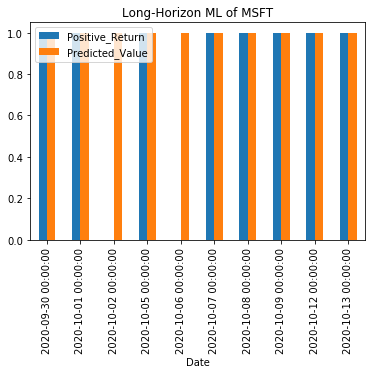

In [86]:
results = random_forest(X_train, X_test, y_train, y_test)
plot = results[['Positive_Return', 'Predicted_Value']].tail(10).plot(kind="bar",title="Long-Horizon ML of "+ticker)
from sklearn.metrics import classification_report
print(classification_report(results.Positive_Return,results.Predicted_Value))

### Short-Horizon ML model, plot and evaluation

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.83      1.00      0.91         5

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



C:\Users\khuli\anaconda3\envs\pyvizenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


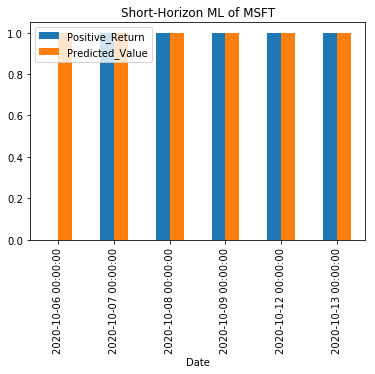

In [87]:
results = random_forest(X_train_2, X_test_2, y_train_2, y_test_2)
plot = results[['Positive_Return', 'Predicted_Value']].tail(10).plot(kind="bar",title="Short-Horizon ML of " + ticker)
print(classification_report(results.Positive_Return,results.Predicted_Value))